# Demonstration of Bias Triangle Feature Pipeline on data from a FinFet device

Minimum parameters are

__res:__ Resolution factor

__min_area:__ Minimum contour area (to remove outliers)

__thr_method:__ Image Thresholding Method (_'noisy_binary'_ preferred for dataset with gaps, _'triangle'_ for better-defined close-ups)

__denoising (bool):__ Applies denoising as preprocessing 

__allow_MET (bool):__ In case of disconnected contours (i.e. bias triangles with distinct gaps), employs Minimum 
    Enclosing Triangle(MET), instead of a variation of the Ramer-Douglas-Peucker (RDP) algorithm
    
__direction:__ User-supplied direction of bias triangles

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 as cv
from typing import Tuple

In [3]:
imgs = np.load('finfets_imgs.npy', allow_pickle=True)
labels = np.load('finfets_labels.npy', allow_pickle=True)

In [4]:
import btriangle_detection, btriangle_properties
import cv2 as cv
from btriangle_detection import PSB_detector, triangle_segmentation_alg
from btriangle_properties import detect_base



def bias_triangle_pipeline(img: np.ndarray, res: int, min_area: int, thr_method: str, denoising: bool, allow_MET: bool, direction: str, median: bool = False) -> None:

    gray_orig, ims, masks = btriangle_detection.triangle_segmentation_alg(img, res = res, min_area = min_area, thr_method = thr_method, denoising = denoising, allow_MET = allow_MET, direction = direction)

    base, corner_pts, c_im = btriangle_properties.detect_base(gray_orig, masks, 'down')
    angles, angl_img = btriangle_properties.compute_angles(gray_orig, np.array(corner_pts), 'MET')

    print('The angles (as per MET) in degrees are ', angles)

    exc_state, line_mask = btriangle_properties.get_excited_state(gray_orig, base,'down', tol = 0.3)
    
    idx = np.argsort(exc_state[:, 1])
    exc_state = exc_state[idx, :]

    if median == True:
        
        median_line = len(idx) // 2
        ex_line = exc_state[median_line]
        
    else:
        ex_line = exc_state[-1]
    
    points = ex_line[2:]
    x_coords, y_coords = (points[0], points[2]), (points[1], points[3])
    slope_b, b_intc = btriangle_properties.get_line(base.flatten())
    y_int = np.mean([points[1] - points[0]*slope_b, points[3] - points[2]*slope_b])
    n_y1 = slope_b* points[0]+y_int
    n_y2 = slope_b* points[2]+y_int
 
    ex_line = np.array([slope_b, y_int, points[0], n_y1, points[2], n_y2])

    contour, _ = cv.findContours(masks,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    intersection = btriangle_properties.extract_triangle_seg(gray_orig, base, ex_line, contour[0])
    _, _ , tr_int = btriangle_properties.extract_props(intersection, gray_orig)

    _, _ , tr_int_all = btriangle_properties.extract_props(contour[0], gray_orig)

    blank = gray_orig.copy()
    seg_im = cv.drawContours(blank, [intersection], -1,(255,0,255), thickness=1)

    axes_points,axes,line_img = btriangle_properties.detect_detuning_axis(gray_orig, base, corner_pts)

    print('The mean intensity of the segment is', tr_int, 'while the mean intensity of the triangle is', tr_int_all)
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6),sharex=True, sharey=True)

    ax[0,0].imshow(gray_orig) 
    ax[0,0].axis('off') 
    ax[0,0].set_title('Original') 

    
    ax[0,1].imshow(ims[0]) 
    ax[0,1].axis('off') 
    ax[0,1].set_title('Segmentation') 

    ax[0,2].imshow(masks) 
    ax[0,2].axis('off') 
    ax[0,2].set_title('Mask') 


    ax[0,3].imshow(c_im) 
    ax[0,3].axis('off') 
    ax[0,3].set_title('Corner Points & Base') 

    ax[1,0].imshow(angl_img) 
    ax[1,0].axis('off') 
    ax[1,0].set_title('Convex Enclosing Triangle (MET)') 


    ax[1,1].imshow(line_mask) 
    ax[1,1].axis('off') 
    ax[1,1].set_title('Detected lines') 

    ax[1,2].imshow(seg_im) 
    ax[1,2].axis('off') 
    ax[1,2].set_title('Triangle Segment')

    ax[1,3].imshow(line_img) 
    ax[1,3].axis('off') 
    ax[1,3].set_title('Detected Detuning Axes')

    fig.tight_layout()
    
    return fig

# Example 1

The angles (as per MET) in degrees are  [40.9130418465525, 56.62637236793392, 82.46058578551359]
The mean intensity of the segment is 34.55953590785908 while the mean intensity of the triangle is 38.21826398501751


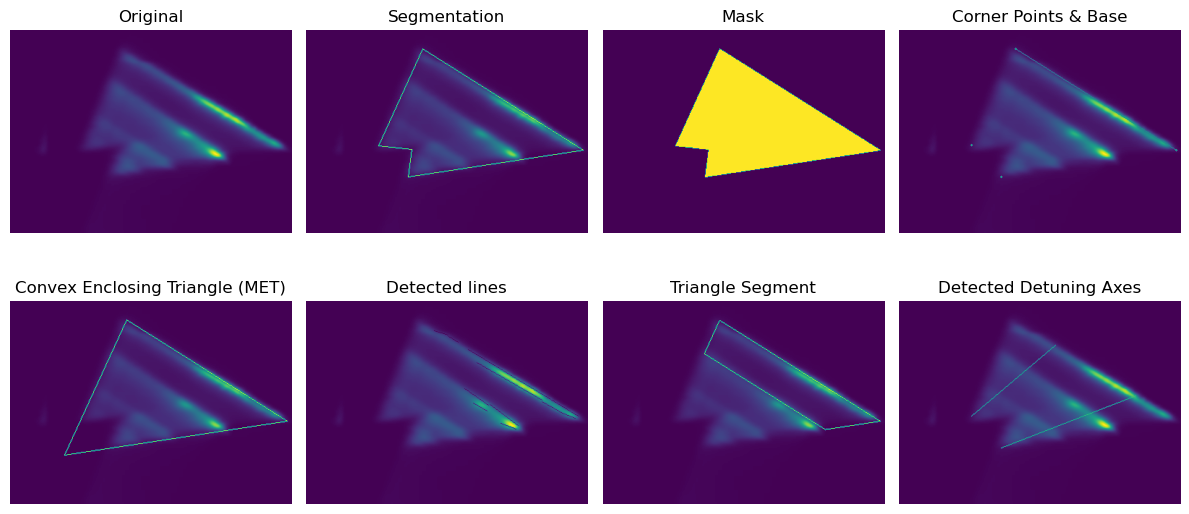

In [9]:
bias_triangle_pipeline(imgs[2][1],res = 2, min_area = 15, thr_method = 'noisy_binary', denoising = True, allow_MET = True, direction = 'down', median = True)
plt.show()

# Example 2

The angles (as per MET) in degrees are  [83.1660001311708, 43.98275450528992, 52.85124536353928]
The mean intensity of the segment is 107.11900915455035 while the mean intensity of the triangle is 72.0086241637785


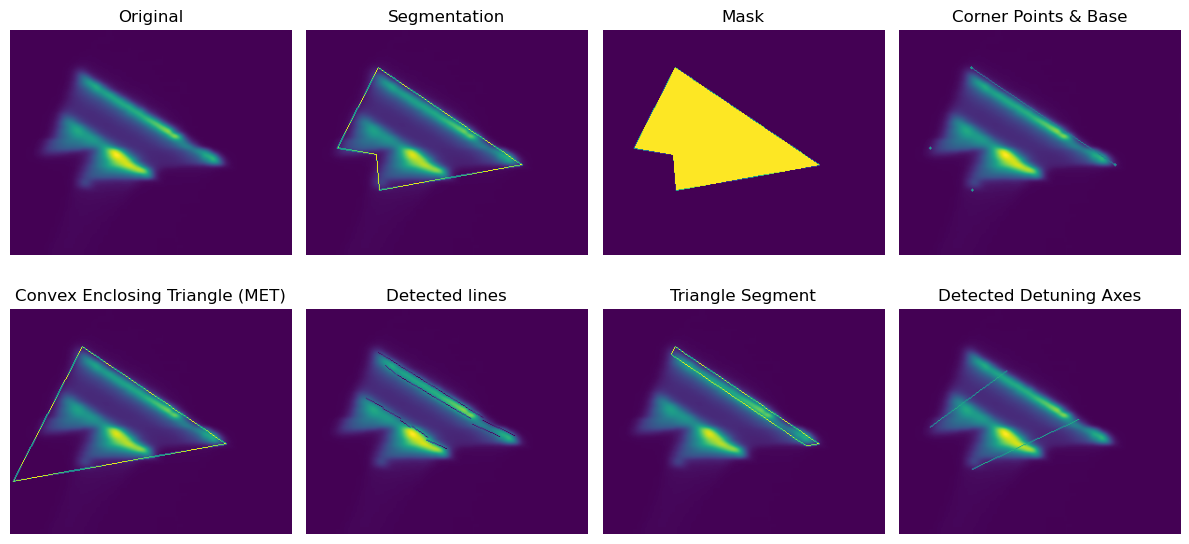

In [10]:
bias_triangle_pipeline(imgs[4][1],res = 2, min_area = 15, thr_method = 'noisy_binary', denoising = True, allow_MET = True, direction = 'down', median = True)
plt.show()

# Example 3

The angles (as per MET) in degrees are  [83.4696471619304, 40.39072864724999, 56.1396241908196]
The mean intensity of the segment is 27.02911051212938 while the mean intensity of the triangle is 42.00753541645735


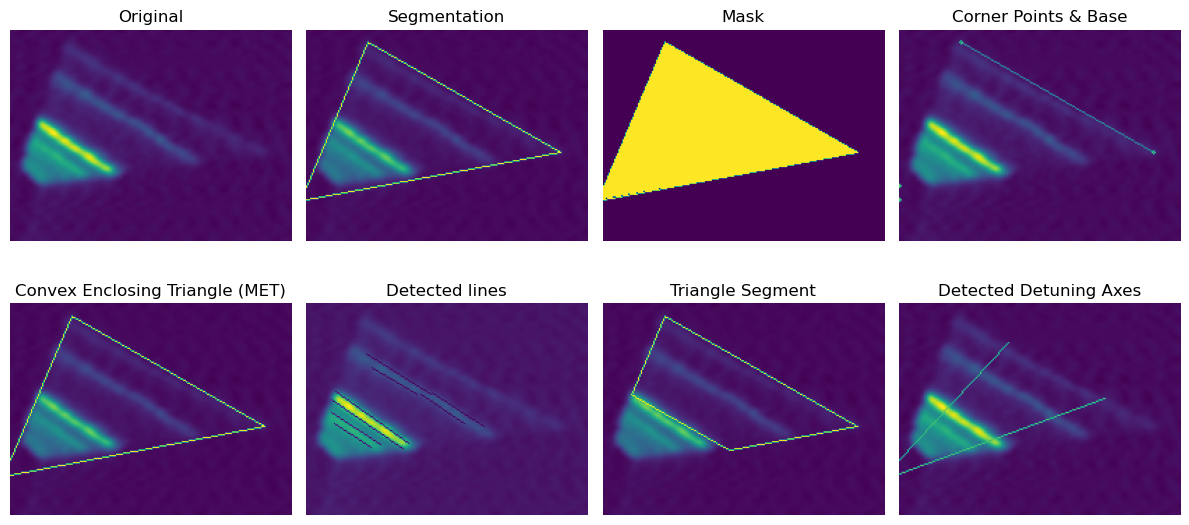

In [11]:
bias_triangle_pipeline(imgs[16][1],res = 2, min_area = 15, thr_method = 'noisy_binary', denoising = True, allow_MET = True, direction = 'down', median = True)
plt.show()

# Example 4

The angles (as per MET) in degrees are  [39.73415968822089, 62.85622325731425, 77.40961705446486]
The mean intensity of the segment is 80.48424068767908 while the mean intensity of the triangle is 52.62169919632606


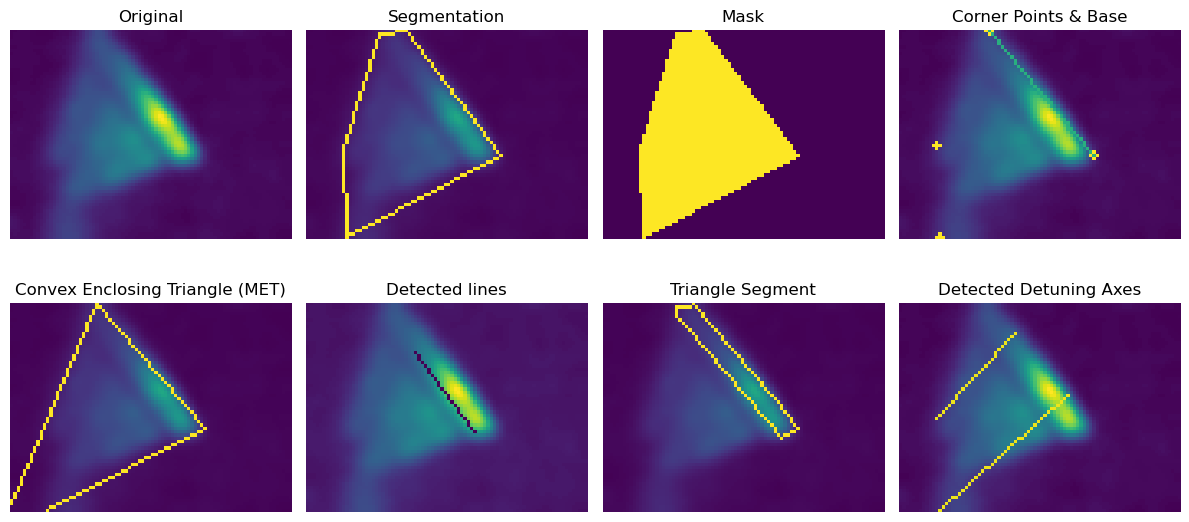

In [12]:
bias_triangle_pipeline(imgs[35][1],res = 2, min_area = 15, thr_method = 'noisy_binary', denoising = True, allow_MET = True, direction = 'down', median = True)
plt.show()

# Example 5

The angles (as per MET) in degrees are  [90.01046116101449, 44.12952964706832, 45.8600091919172]
The mean intensity of the segment is 40.63091842555619 while the mean intensity of the triangle is 57.55527817403709


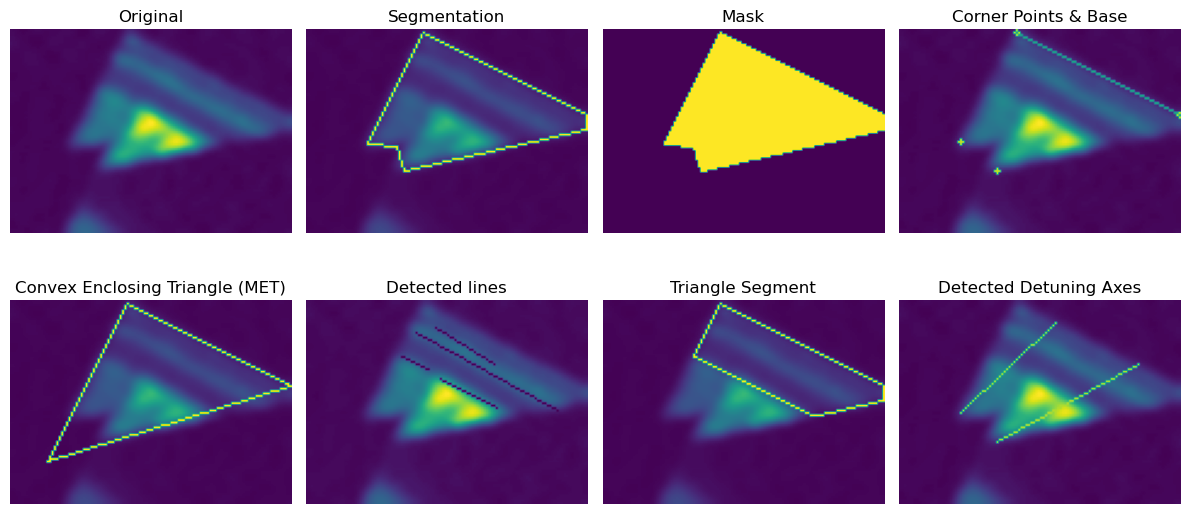

In [13]:
bias_triangle_pipeline(imgs[25][1],res = 2, min_area = 200, thr_method = 'noisy_binary', denoising = True, allow_MET = True, direction = 'down', median = True)
plt.show()

# Example 6

The angles (as per MET) in degrees are  [31.521587533585528, 62.13733071480568, 86.34108175160881]
The mean intensity of the segment is 27.25201563645248 while the mean intensity of the triangle is 37.93554840734348


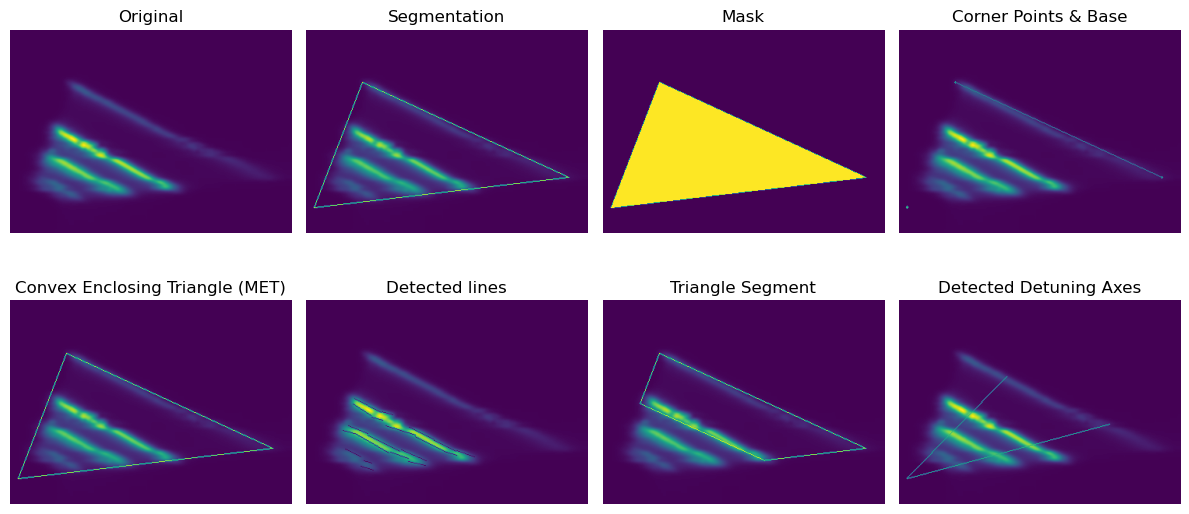

In [14]:
bias_triangle_pipeline(imgs[0][1],res = 2, min_area = 15, thr_method = 'noisy_binary', denoising = True, allow_MET = True, direction = 'down', median = True)
plt.show()

# Detection of Pauli Spin Blockade (PSB)
We detect PSB by comparing the averaged intensities per triangle segment (respectively normalized by total triangle intensity). We determine the segment on the detected mask of the unblocked bias triangle by selecting the base and the median of the detected (excited state) lines as boundaries. Then we compare it to the intensity of the blocked bias triangle. Normalization is conducted with respect to the complete triangle average intensity (respectively) to account for uniform variations in intensity.

The parameter _int_tol_ specifies the minimum deviation in intensity above which PSB is detected, while the parameter _slope_tol_ specifies the maximum deviation in absolute value between slopes of detected (excited state) lines.

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

PSB_List = []
intensity_pairs = []

for j in range(len(imgs)):
    
    PSB_List = []
intensity_pairs = []
intensity_diff = []

for j in range(len(imgs)):

    res_h = 4
    min_area_pc = 0.0001
    min_area_h = (imgs[j][1].shape[0]*imgs[j][1].shape[1]*res_h*res_h)*min_area_pc

    unblocked, ims, masks = btriangle_detection.triangle_segmentation_alg(imgs[j][1],res = res_h, min_area = min_area_h, thr_method = 'noisy_binary', denoising = True, allow_MET = True, direction = 'down')
    base, corner_pts, c_im = btriangle_properties.detect_base(unblocked, masks, 'down')

    blocked,ims2, masks2 = btriangle_detection.triangle_segmentation_alg(imgs[j][0],res = res_h, min_area = min_area_h, thr_method = 'noisy_binary', denoising = True,allow_MET = True, direction = 'down')
    
    pair, PSB = btriangle_detection.PSB_detector(unblocked, blocked, base, masks, 'down', slope_tol = 0.4, int_tol = 0.05, median = True)  
    intensity_pairs.append(pair)
    
    if len(pair) > 0:
            
            intensity_diff.append(abs(pair[0]-pair[1]))
            
    else:
            
            intensity_diff.append(-1)
    
    PSB_List.append(int(PSB))
    
PSB_N = np.array(PSB_List)    
acc = accuracy_score(labels, PSB_N)

print('The PSB detector is ',round(acc*100,2),'% accurate in',round(len(PSB_N)/len(imgs)*100,2),'% of the data, with recall ',round(recall_score(labels, PSB_N)*100,2),'% and precision ', round(precision_score(labels, PSB_N)*100,2),'%.')               

/Users/madeleine/Downloads/btriangle_properties.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y_coords)[0]


No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
No lines found, potentially increase tolerance for slope deviation.
The PSB detector is  90.57 % accurate in 100.0 % of the data, with recall  94.74 % and precision  81.82 %.


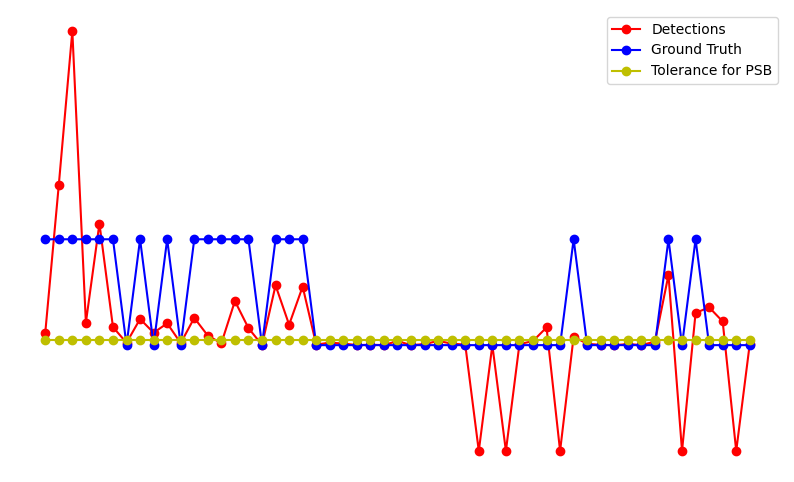

In [24]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(PSB_N)),np.array(intensity_diff),'-or')
plt.plot(np.arange(0,len(PSB_N)),labels.tolist(),'-ob')
plt.plot(np.arange(0,len(PSB_N)),np.ones(len(imgs))*0.05,'-oy')
plt.axis('off')
plt.legend(['Detections', 'Ground Truth', 'Tolerance for PSB'])
plt.show()